## Assignment 3
Chen Liang

In [2]:
#sc.install_pypi_package("seaborn")
#sc.install_pypi_package("pandas")
from pyspark.sql.functions import col, size, length, split
import seaborn as sns
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
data = spark.read.parquet('s3://amazon-reviews-pds/parquet/product_category=Books/*.parquet')
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 15
Total Rows: 20726160

## 1. Feature Engineering
In Lab6, we only used `total_votes` for the logistic regression model, where `y = star_rating >= 4`. In my model, I am going to add 4 more variables: `helpful_votes`, `reveiw_length`, `is_vine`, and `is_purchase`. The latter two are categorical features.

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
tokenizer = Tokenizer(inputCol='review_body', outputCol='text')
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='terms')
hasher = HashingTF(inputCol=remover.getOutputCol(), outputCol="hash")
idf = IDF(inputCol=hasher.getOutputCol(), outputCol="review_features")
pipeline = Pipeline(stages=[tokenizer, remover, hasher, idf])
## for training, I actually only used length(terms), because it takes too much
## time to train with idf.
data = data.na.drop()
data = pipeline.fit(data).transform(data)

In [4]:
## Engineer the feature for use
data = data.withColumn('good_review', (data.star_rating >= 4).cast("integer"))
data = data.withColumn('helpful_votes', (data.helpful_votes).cast("integer"))
data = data.withColumn('total_votes', (data.total_votes).cast("integer"))
data = data.withColumn('review_length', (size('terms').cast("integer")))
## one feature derived from text data
data = data.withColumn('is_vine', (data.vine == "Y").cast('integer'))
data = data.withColumn('is_purchase', (data.verified_purchase == "Y").cast('integer')) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
data = data.select(['good_review', 'helpful_votes', 'total_votes', 'review_length',
                    'is_vine', 'is_purchase'])
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- good_review: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- review_length: integer (nullable = false)
 |-- is_vine: integer (nullable = true)
 |-- is_purchase: integer (nullable = true)

### Helpful and Total Votes
As shown in the boxplots below, helpful and total votes are strong indicators of star ratings. People tend to believe that extremely bad (star=1) reviews are the most helpful votes.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

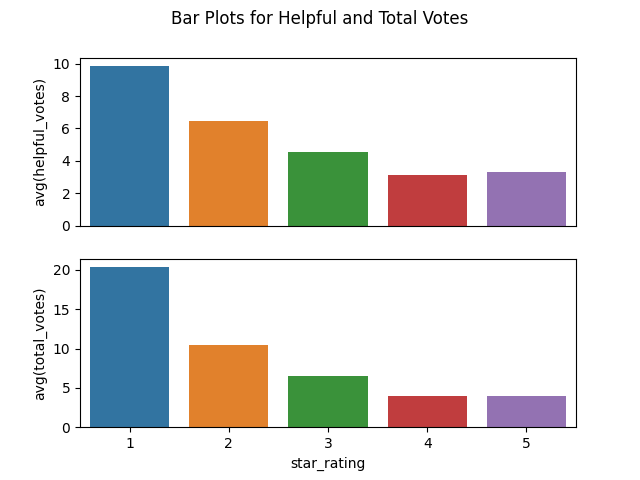

In [5]:
votes_avg = (data.groupBy('star_rating')
                 .mean('helpful_votes', 'total_votes')
                 .sort('star_rating', ascending=False)
                ) 
df = votes_avg.toPandas()
plt.close(); fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Bar Plots for Helpful and Total Votes')
sns.barplot(x='star_rating', y="avg(helpful_votes)", data=df, ax=ax1)
sns.barplot(x='star_rating', y="avg(total_votes)", data=df, ax=ax2)
ax1.set_xticks([]); ax1.set_xlabel(None); plt.show()
%matplot plt

### Review Length
As shwon in the graph below, it seems that there is a non-linear correlation between the length of a review and its corresponding star rating. Those who are most satisfied (rating = 5) with the product tend to write less in the review--and therefore might be useful as a predictor. However, the length difference in ratings are not salient. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

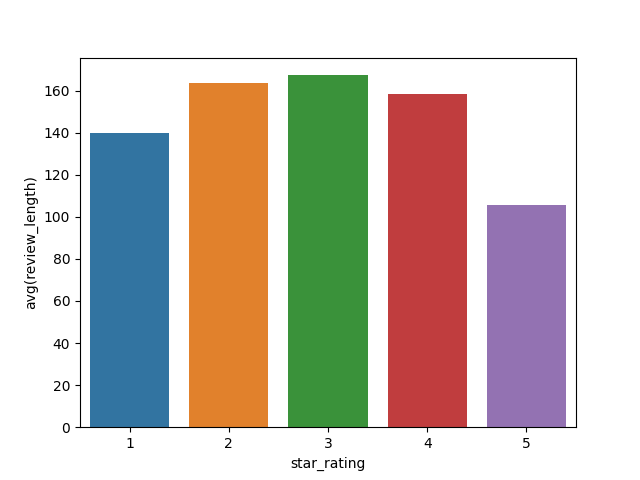

In [5]:
review_length = (data.groupBy('star_rating')
                 .mean('review_length')
                 .sort('star_rating', ascending=False)
                )
df = review_length.toPandas()

plt.close()
sns.barplot(x='star_rating', y="avg(review_length)", data=df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

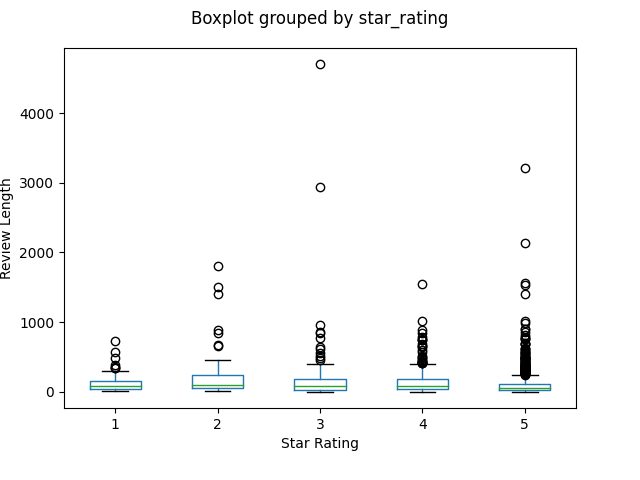

In [8]:
plt.close()
sampled_df = data.sample(fraction=0.0001).toPandas()
sampled_df.boxplot(column=['review_length'], by=['star_rating'], grid = False)
plt.ylabel('Review Length'); plt.xlabel('Star Rating')
plt.title('')
%matplot plt

### Vine and Purchase

"The Amazon Vine Program is a review incentive initiative that employs a hand-picked group of reviewers through Amazon’s platform to review new products. The product can be ordered by a group of pre-selected reviewers (called Vine Voices) who give an honest review of the product. In exchange for the review, they receive the product for free." https://www.repricerexpress.com/amazon-vine-program/

Apparently, those pre-selected reviewers tend to be more neutral in their reviews, or other people have less motivation to post a review when they do not have a strong opinion on the product. Also, those who did purchase a product tend to have a slightly higher rating on the product. Because of these differences, is_vine and is_purchase can be nice predictors.


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

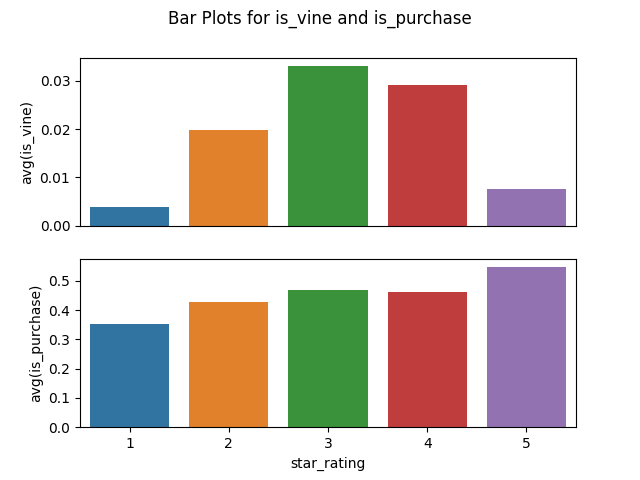

In [82]:
vine_purchase = (data.groupBy('star_rating')
                 .mean('is_vine', 'is_purchase')
                 .sort('star_rating', ascending=False)
                )
df = vine_purchase.toPandas()

plt.close(); fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Bar Plots for is_vine and is_purchase')
sns.barplot(x='star_rating', y="avg(is_vine)", data=df, ax=ax1)
sns.barplot(x='star_rating', y="avg(is_purchase)", data=df, ax=ax2)
ax1.set_xticks([]); ax1.set_xlabel(None); plt.show()
%matplot plt

## 2. Balancing Data

In [17]:
train, test = data.randomSplit([0.5, 0.5], seed = 23)
print(train.count(), test.count())
train.groupBy("good_review").count().orderBy("good_review").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10360985 10365175
+-----------+-------+
|good_review|  count|
+-----------+-------+
|          0|1757205|
|          1|8603780|
+-----------+-------+

In [7]:
a0 = 2461765; a1 = 12047374
sampled_train = train.sampleBy("good_review", fractions={0: 1, 1: a0/a1}, seed=0)
sampled_train.groupBy("good_review").count().orderBy("good_review").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------+
|good_review|  count|
+-----------+-------+
|          0|2461765|
|          1|2461662|
+-----------+-------+

## 3. Implementing a Reproducible Machine Learning Pipeline

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
features = ['helpful_votes', 'total_votes', 
            'review_length', 'is_vine', 'is_purchase']
assembler = VectorAssembler(inputCols = features, outputCol = 'features')
regression = LogisticRegression(featuresCol='features', labelCol='good_review')
pipeline = Pipeline(stages = [assembler, regression])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
params = ParamGridBuilder()
params = params.addGrid(regression.regParam,  np.arange(0, .1, 0.01))
params = params.addGrid(regression.elasticNetParam, [0, 1])
params = params.build()
evaluator = BinaryClassificationEvaluator().setLabelCol('good_review')
cv = CrossValidator(estimator = pipeline,
                    estimatorParamMaps = params,
                    evaluator = evaluator,
                    numFolds = 5, seed = 13)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

So far, we haven't yet started to run the models. That is, the dataframe is not actually processed when I chain together a sequence of transformations in a pipeline, because we are just specifying the stages that each model need to go through. Spark process the DataFrame according to the specified transformations when it receives data from each cross-validation train set. That is, pipeline will only run when I call the fit function.

## 4. Finding Optimal Model Parameter

In [24]:
model = cv.fit(sampled_train)
print(max(model.avgMetrics))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.7287067497578597

In [44]:
trainingSummary = model.bestModel.stages[-1].summary
print("Training AUC: " + str(trainingSummary.areaUnderROC))
print("Test AUC: ", str(evaluationSummary))
print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))    
print("\nTraining Accuracy: " + str(trainingSummary.accuracy))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.727710680918522
Test AUC:  0.7284259363090377

False positive rate by label (Training):
label 0: 0.1509021141001486
label 1: 0.5101518625863963

True positive rate by label (Training):
label 0: 0.48984813741360367
label 1: 0.8490978858998514

Training Accuracy: 0.6694692538347781

In [56]:
prediction = model.bestModel.transform(sampled_train)
prediction.groupBy('good_review', 'prediction').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+-------+
|good_review|prediction|  count|
+-----------+----------+-------+
|          1|       1.0|2090192|
|          0|       0.0|1205891|
|          0|       1.0|1255874|
|          1|       0.0| 371470|
+-----------+----------+-------+

In [57]:
prediction = model.bestModel.transform(test)
prediction.groupBy('good_review', 'prediction').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+-------+
|good_review|prediction|  count|
+-----------+----------+-------+
|          1|       1.0|7306768|
|          0|       0.0| 862020|
|          0|       1.0| 898485|
|          1|       0.0|1297902|
+-----------+----------+-------+

In summary, our best model got an AUC of 0.73 on sampled train data and an AUC of 0.73 on test data. This is a slight but not satisfiable improvement compared to the original model. Particularly, it tends to misclassify negative reviews as positive reviews. It is poor probably because we need to feed in more data and, particularly, extract more useful information from the string data variables. 